In [2]:
import numpy as np
from scipy import ndimage, sparse
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, Ridge

# Bits and pieces of convex optimization : the Alternating direction method of multipliers (ADMM)

In this notebook, we will focus on relatively simple yet extremely versatile convex solver: ADMM.
For that purpose, consider a *convex problem with equality constaints*

$$
\begin{aligned}
    \mathrm{minimize} & \quad f(x) \\
    \mathrm{subject~to} & \quad Ax = b.
\end{aligned}
$$

Before diving into the ADMM algorithm, let us define terminology here.

**Lagrangian** The Lagrangian of the this problem is given by $L(x, y) = f(x) + y^T ( Ax - b )$.

**Dual function** The dual function is defined as $g(y) = \inf_x L(x, y)$.

**Dual problem** To each *primal* problem, we can associate a *dual problem*

$$
\mathrm{maximize} \quad g(y).
$$

Once we have solved the dual problem, we can recover the solution of the original primal problem as

$$
x_{\star} = \mathrm{argmin}_x L(x, y_{\star}).
$$

#### Dual Ascent

A simple algorithm to solve this problem is the dual ascent method.
It essentially consists in two steps:

$$
\begin{aligned}
    x_{k+1} & = \mathrm{argmin}_x L(x, y_k) \\
    y_{k+1} & = y_k + \alpha_k (A x_{k+1} - b),
\end{aligned}
$$

it alternates a minimization step for $x$ with a dual update rule for $y$.
Note that this dual ascent algorithm effectively works although a lot of strong assumptions need to be satisfied.

#### Method of mulitpliers

The dual ascent method can be robustified (i.e. work under looser assumptions) by using the following augmented Lagrangian

$$
L_{\rho}(x, y) = f(x) + y^T(Ax - b) + \dfrac{\rho}{2} \Vert Ax - b \Vert_2^2
$$

with $\rho > 0$. The method of multipliers then performs very similar updates

$$
\begin{aligned}
x_{k+1} & = \mathrm{argmin}_x L_{\rho} (x, y_k) \\
y_{k+1} & = y_k + \rho ( Ax_{k+1} - b).
\end{aligned}
$$

This simple modification of the dual ascent makes the method of multipliers way more robust and converges under much more relaxed conditions. One of the drawback however is that the quadratic penalty can destroy some interesting splitting properties of the problem which could have been leveraged for distributed optimization.

#### Alternating direction method of multipliers

Enters ADMM, a method with the good robustness of the method of multipliers and which can support decomposition (think distributed optimization) proposed as early as 1976.
Suppose the problem we are interested has the following structure

$$
\begin{aligned}
    \mathrm{minimize} \quad f(x) + g(z) \\
    \mathrm{subject~to} \quad Ax + Bz = c,
\end{aligned}
$$

where $f$ and $g$ are both convex functions.
Let us define the agumented Lagrangian function

$$
L_{\rho}(x, z, y) = f(x) + g(z) + y^T(Ax + Bz - c) + \dfrac{\rho}{2} \Vert Ax + Bz - c \Vert_2^2.
$$

The ADMM update rule then is

$$
\begin{aligned}
x_{k+1} & = \mathrm{argmin}_x L_{\rho}(x, z_k, y_k) \\
z_{k+1} & = \mathrm{argmin}_z L_{\rho}(x_k, z, y_k) \\
y_{k+1} & = y_k + \rho (Ax_{k+1} + Bz_{k+1} -c).
\end{aligned}
$$

If we were to jointly minimize over $x$ and $y$, it would reduces to the method of multipliers.
Since we are however splitting these two steps, this essentially amounts to performing a Gauss-Seidel type of iteration.

## Exercise

In the rest of this notebook, you will implement this ADMM method tailored specifically for the LASSO problem.
Recall that this problem reads

$$
\mathrm{minimize} \quad \dfrac12 \Vert Ax - b \Vert_2^2 + \lambda \Vert x \Vert_1.
$$

Once implemented, let us apply this algorithm to a (synthetic) compressed sensing application.
The cell below implements a sparse image and its random projections from which we'd like to infer the image back.
It also uses `scikit-learn` to showcase the reconstruction capabilities of ridge regression and lasso on this problem.

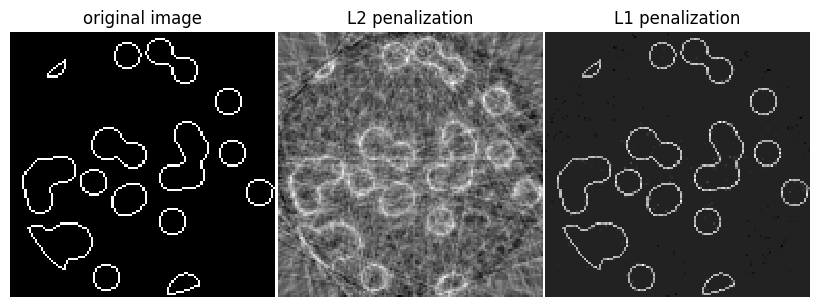

In [6]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.0
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """Synthetic binary data"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("original image")
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L2 penalization")
plt.axis("off")
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L1 penalization")
plt.axis("off")

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()

LASSO works much better than ridge regression for this compressed sensing application.
But how does your ADMM algorithm compares to `scikit-learn` in terms of computational performances ?

In [8]:
%%timeit
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())

192 ms ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())

6.47 s ± 64.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
